# Some evidence of statistical heaping in the review scores.


Awhile back I read a [really cool blog post](https://gutterstats.wordpress.com/2015/11/03/are-nfl-officials-biased-with-their-ball-placement/) about bias in decisions about the line of scrimmage in American Football. The post reported that NFL officials tend to place the line of scrimmage at tidy yard numbers (i.e., 10s and 5s) more often than at less-tidy numbers (e.g., 4s and 6s). The technical term for this is [statistical heaping](http://ww2.amstat.org/sections/SRMS/Proceedings/y1958/Patterns%20Of%20Heaping%20In%20The%20Reporting%20Of%20Numerical%20Data.pdf), and its observed commonly in survey data.


Recently, I have been thinking about whether a similar principle is at work when reviewers assign a score to an album. My guess is that authors usually have  a _general_ sense of the album's score, but they need to pick a _specific_ value (Is this a 7.8? 7.9? 7.7?). In this notebook, I'll just quickly establish the presence of statistical heaping in the review data.

## Loading libraries and data...

In [6]:
rm(list=ls())

library(sqldf)
library(ggplot2)

con = dbConnect(SQLite(), dbname="../pitchfork.db")
scores = dbGetQuery( con, 'SELECT score FROM reviews')
dbDisconnect(con)

print('SCORES SUMMARY')
summary(scores)

print('SCORES STANDARD DEV')
sd(scores$score)

[1] TRUE

[1] "SCORES SUMMARY"


     score       
 Min.   : 0.000  
 1st Qu.: 6.400  
 Median : 7.200  
 Mean   : 7.006  
 3rd Qu.: 7.800  
 Max.   :10.000  

[1] "SCORES STANDARD DEV"


[1] 1.293675

## Models

If there is _no_ statistical heaping in the data, then "round" scores, such as 7.0 and 8.0, should not be more frequently chosen than alternatives (such as 7.1 or 7.9). I'll define two models which characterize what ought to happen, assuming no bias: a _Uniform_ model and a _Normal_ model.

### Uniform Model

This model proposes that reviewers draw each score at random, uniformly between 0.0 and 10.0:

$$
score = uniform(0.0, 10.0)
$$

This is not a very plausible model because we _know_ scores are not uniformly distributed. But it's still worth considering for this issue (I think). Under this model, each score is equally probable, and so each decimal place ( \*.0, \*.1) is also equally likely. The only kink is that \*.0 is a little more probable because 10.0 is a possibility but 10.1-10.9 are not.

### Normal Model

This model is based on the observation that scores are (roughly) normally distributed, with $\mu=7.006$ and $\sigma=1.294$:

$$
score = normal(\mu=7.006, \sigma=1.294)
$$

Obviously, under this model, scores around 7.0 are the most probable.

## Analysis

I'm basically going to count the number of reviews with scores ending at each decimal place, and compare that to what we'd expect under both models. Simple? Let's go!

In [2]:
# ----- Get observed counts
# the rounding is due to a weird issue with the mod operator,
# some scores have a mod of like 0.00000002003 or something nutty.
value = round(as.vector(scores$score) %% 1.0, 1) 
observed = as.data.frame(table(value))
colnames(observed) <- c('decimal','count')
observed

decimal,count
0,2776
0.1,1392
0.2,1749
0.3,1602
0.4,1723
0.5,2049
0.6,1571
0.7,1662
0.8,2151
0.9,1718


In [3]:
# ----- Compute expected values assuming uniform choices
uniform = as.data.frame(table(round(seq(0,10,0.1) %% 1.0,1)))
colnames(uniform) = c('decimal','count')
uniform$proportion = uniform$count / sum(uniform$count)
uniform$count = uniform$proportion * sum(observed$count)
uniform

decimal,count,proportion
0,2003.198,0.1089109
0.1,1821.089,0.0990099
0.2,1821.089,0.0990099
0.3,1821.089,0.0990099
0.4,1821.089,0.0990099
0.5,1821.089,0.0990099
0.6,1821.089,0.0990099
0.7,1821.089,0.0990099
0.8,1821.089,0.0990099
0.9,1821.089,0.0990099


In [4]:
# ----- compute expected values assuming normal choices
x = seq(0,10,0.1)
m = mean(scores$score)
s = sd(scores$score)
density = dnorm(x, mean = m, sd = s)
p = density / sum(density)
idx = round(x %% 1.0,1)
normal = data.frame(list(score = x, decimal = idx, prob = p))
normal = aggregate(normal$prob, by=list(normal$decimal), FUN=sum)
colnames(normal) = c('decimal','proportion')
normal$count = normal$proportion * sum(observed$count)
normal

decimal,proportion,count
0.0,0.10065429,1851.334
0.1,0.09893412,1819.695
0.2,0.09928866,1826.216
0.3,0.09958802,1831.722
0.4,0.09983921,1836.343
0.5,0.10004867,1840.195
0.6,0.10022226,1843.388
0.7,0.10036521,1846.017
0.8,0.10048221,1848.169
0.9,0.10057736,1849.919


## Plotting

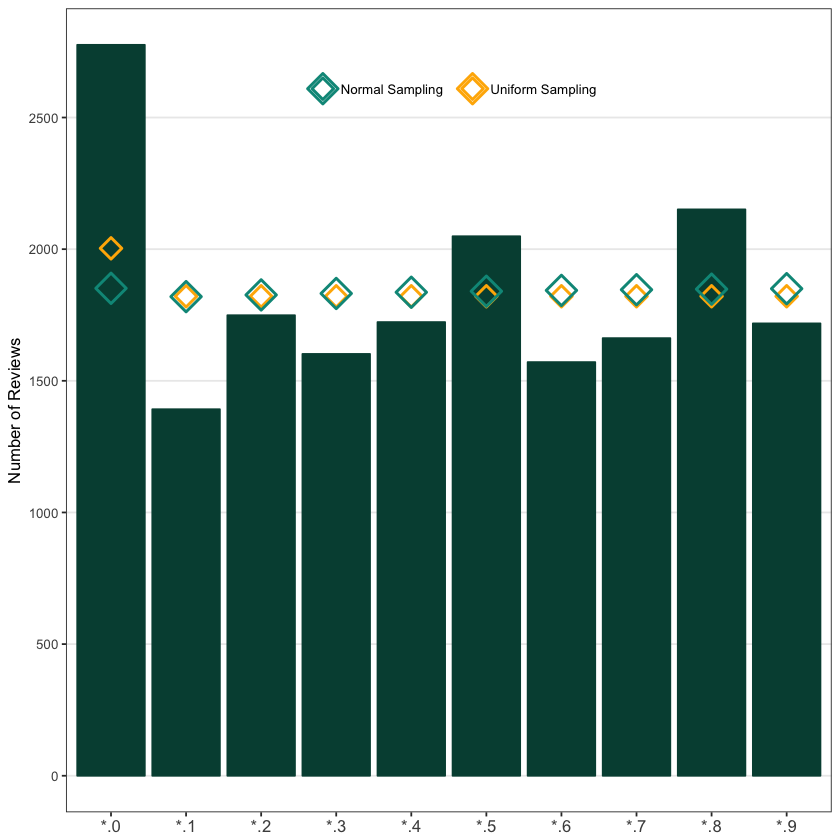

In [5]:
# get x ticks !
xticklabs = character()
for (i in 0:9) {
	xticklabs = c(xticklabs, paste0('*.',toString(i)))
}

plot = ggplot(NULL, aes(x = decimal, y = count)) + 
	geom_bar(data = observed, stat = 'identity', colour = '#004D40' , fill = '#004D40') + 
	geom_point(data = uniform, aes(colour = 'Uniform Sampling'), 
		stroke = 1.25, size = 4, shape = 23) + 
	geom_point(data = normal, aes(x = 1:10, colour = 'Normal Sampling   '), 
		stroke = 1.25, size = 6, shape = 23) + 
	ylab("Number of Reviews") +
	scale_y_continuous(breaks = seq(from=0,to=3000,by=500)) +
	scale_x_discrete(breaks=observed$decimal, labels=xticklabs) +
	theme_bw(base_size = 10) +
	theme(
		axis.title.x=element_blank(),
		panel.grid.major.x = element_blank(),
		legend.direction="horizontal", 
		legend.title = element_blank(),
	  	legend.position = c(0.5, 0.9),
	  	panel.grid.minor.y = element_blank(),
	  	axis.text.x  = element_text(size=10),
	  ) + 
	scale_colour_manual(values=c("#009688", "#FFB300"))
print(plot)

## Results

Obviously, \*.0 is selected _far_ more often than you'd expect if scoring was unbiased. I think this is pretty strong evidence of statistical heaping!